In [1]:
import os
import pandas as pd
from datetime import datetime
import time
import math
import numpy as np
import networkx as nx
import copy
import random
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'C:\\Users\\Vojta\\Desktop\\own\\university\\ing\\01\\madII_projects\\analysis'

In [118]:
name_of_file = 'ia-retweet-pol.edges'

In [3]:
name_of_file = 'fb-messages.edges'

In [4]:
path_to_file = f'.\\ds\\{name_of_file}'

In [5]:
!pip install pandas

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [6]:
dataset = pd.read_csv(path_to_file, sep=',', header=None)

In [7]:
dataset.head()

,0,1,2
0,730,730,1.080091e+09
1,563,563,1.080091e+09
2,674,674,1.080718e+09
3,571,571,1.081366e+09
4,667,667,1.082013e+09


In [8]:
dataset['converted_time'] = dataset.iloc[:, 2].apply(time.ctime)

In [9]:
dataset.head()

,0,1,2,converted_time
0,730,730,1.080091e+09,Wed Mar 24 02:11:55 2004
1,563,563,1.080091e+09,Wed Mar 24 02:12:20 2004
2,674,674,1.080718e+09,Wed Mar 31 09:20:04 2004
3,571,571,1.081366e+09,Wed Apr 7 21:33:48 2004
4,667,667,1.082013e+09,Thu Apr 15 09:08:31 2004


In [10]:
dataset = dataset.sort_values(by=2)

In [11]:
dataset.head()

,0,1,2,converted_time
0,730,730,1.080091e+09,Wed Mar 24 02:11:55 2004
1,563,563,1.080091e+09,Wed Mar 24 02:12:20 2004
2,674,674,1.080718e+09,Wed Mar 31 09:20:04 2004
3,571,571,1.081366e+09,Wed Apr 7 21:33:48 2004
4,667,667,1.082013e+09,Thu Apr 15 09:08:31 2004


In [12]:
START_UNIX = 1.080091e+09

In [13]:
first = dataset.iloc[0]
first.converted_time

'Wed Mar 24 02:11:55 2004'

In [14]:
last = dataset.iloc[-1]
last.converted_time

'Tue Oct 26 07:52:22 2004'

In [15]:
NUMBER_OF_LAYERS = 7

In [16]:
interval = last[2] - first[2]

In [17]:
interval

18679227.0

In [18]:
size = math.ceil(interval / NUMBER_OF_LAYERS)

In [19]:
size

2668461

In [20]:
START_UNIX + size * 3

1088096383.0

In [21]:
last[2]

1098769942.0

In [22]:
def create_sub_df(step, index, last_end_index, data, last=False):
    end_value = START_UNIX + index * step
    time_values = data.iloc[:, 2].values

    if last:
        print('end')
        f_i = int(last_end_index) #from index
        sub_df = data.iloc[f_i:, :]
        return sub_df, None
        
    
    
    find_value = end_value
    v = None
    while True:
        v = np.argwhere(time_values == find_value).flatten()
        
        if(len(v) > 0):
            print(v)
            print('Found')
            
            break
        find_value -= 1

    f_i = int(last_end_index) #from index
    t_i = int(v[-1] + 1) #to index 

    sub_df = data.iloc[f_i:t_i, :]
    my_end_index = t_i
    return sub_df, my_end_index

In [23]:
sub_dfs = []
last_end_index = 0
for i in range(NUMBER_OF_LAYERS):
    transformed_i = i + 1
    sub_df, last_end_index = create_sub_df(size, transformed_i, last_end_index, dataset, transformed_i==NUMBER_OF_LAYERS)
    sub_dfs.append(sub_df)

[734]
Found
[35360]
Found
[51515]
Found
[55306]
Found
[58116]
Found
[60561]
Found
end


In [24]:
len(sub_dfs)

7

# Check len

In [25]:
for i in range(len(sub_dfs)):
    sub_len = len(sub_dfs[i])
    print(f'DF{i} - {sub_len}')

DF0 - 735
DF1 - 34626
DF2 - 16155
DF3 - 3791
DF4 - 2810
DF5 - 2445
DF6 - 1172


In [26]:
len(dataset) == np.sum([len(df) for df in sub_dfs]) #correct multilayer

True

In [27]:
def from_df_g(sub_df):
    G = nx.from_pandas_edgelist(sub_df, 0, 1)
    return G

In [28]:
#Gs without appended nodes
Gs = []

In [29]:
nodes_ids_1 = dataset.iloc[:, 0]
nodes_ids_2 = dataset.iloc[:, 1]


nodes_ids = np.unique(np.array(list(np.unique(nodes_ids_1)) +  list(np.unique(nodes_ids_2))))

In [30]:
for s_df in sub_dfs:
    s_G = from_df_g(s_df)
    Gs.append(s_G)

In [31]:
Gs_appended = Gs.copy()

In [32]:
#append not existing actors to Gs
for current_G in Gs_appended:
    current_nodes = current_G.nodes() 
    need_to_append = list(filter(lambda x: x not in current_nodes, nodes_ids)) 

    for node_to_append in need_to_append:
        current_G.add_node(node_to_append)

In [33]:
UNIQUE_NODES = (len(nodes_ids))
print(UNIQUE_NODES)

1899


In [34]:
Gs_len = np.sum([len(g.nodes()) for g in Gs])
print(Gs_len)

13293


In [35]:
Gs_len_appended = np.sum([len(g.nodes()) for g in Gs_appended]) 
print(Gs_len_appended)

13293


In [36]:
labels = list(Gs[0].nodes())

In [37]:
sub_dfs[0]

,0,1,2,converted_time
0,730,730,1.080091e+09,Wed Mar 24 02:11:55 2004
1,563,563,1.080091e+09,Wed Mar 24 02:12:20 2004
2,674,674,1.080718e+09,Wed Mar 31 09:20:04 2004
3,571,571,1.081366e+09,Wed Apr 7 21:33:48 2004
4,667,667,1.082013e+09,Thu Apr 15 09:08:31 2004
...,...,...,...,...
730,678,452,1.082756e+09,Fri Apr 23 23:38:40 2004
731,327,327,1.082756e+09,Fri Apr 23 23:39:39 2004
732,1270,399,1.082756e+09,Fri Apr 23 23:41:14 2004
733,1270,1483,1.082757e+09,Fri Apr 23 23:46:46 2004


In [38]:
LAYER_LABELS = []

for i in range(NUMBER_OF_LAYERS):
    current_df = sub_dfs[i]
    start = current_df.iloc[0]
    end = current_df.iloc[-1]
  

    WORD_TITLE = f'Od {start.converted_time} - Do {end.converted_time}'
    print(WORD_TITLE)
    start_string = start.converted_time.replace(' ', '_').replace(':', '_')
    end_string = end.converted_time.replace(' ', '_').replace(':', '_')
    
    
    
#    print(start_string)
 #   print(end_string)
    layer_name = f'{start_string}---{end_string}'
    LAYER_LABELS.append(layer_name)
    


Od Wed Mar 24 02:11:55 2004 - Do Sat Apr 24 00:30:38 2004
Od Sat Apr 24 00:57:38 2004 - Do Mon May 24 21:44:12 2004
Od Mon May 24 21:48:09 2004 - Do Thu Jun 24 18:43:14 2004
Od Thu Jun 24 21:25:43 2004 - Do Sun Jul 25 15:52:25 2004
Od Sun Jul 25 16:22:15 2004 - Do Wed Aug 25 13:23:15 2004
Od Wed Aug 25 15:03:21 2004 - Do Sat Sep 25 10:18:52 2004
Od Sat Sep 25 16:29:27 2004 - Do Tue Oct 26 07:52:22 2004


In [39]:
LAYER_LABELS

['Wed_Mar_24_02_11_55_2004---Sat_Apr_24_00_30_38_2004',
 'Sat_Apr_24_00_57_38_2004---Mon_May_24_21_44_12_2004',
 'Mon_May_24_21_48_09_2004---Thu_Jun_24_18_43_14_2004',
 'Thu_Jun_24_21_25_43_2004---Sun_Jul_25_15_52_25_2004',
 'Sun_Jul_25_16_22_15_2004---Wed_Aug_25_13_23_15_2004',
 'Wed_Aug_25_15_03_21_2004---Sat_Sep_25_10_18_52_2004',
 'Sat_Sep_25_16_29_27_2004---Tue_Oct_26_07_52_22_2004']

# Save gephi

In [40]:
PATH_TO_GEPHI = f'outputs\\gephi\\'

In [41]:
os.getcwd() + PATH_TO_GEPHI

'C:\\Users\\Vojta\\Desktop\\own\\university\\ing\\01\\madII_projects\\analysisoutputs\\gephi\\'

In [42]:
SAVE_GRAPHS = True

In [43]:
if SAVE_GRAPHS:
    for i, G in enumerate(Gs):
        name = LAYER_LABELS[i]
        path = f'{PATH_TO_GEPHI}GRAPH{i}_{name}.gexf'
        print(path)
        nx.write_gexf(G, path)

outputs\gephi\GRAPH0_Wed_Mar_24_02_11_55_2004---Sat_Apr_24_00_30_38_2004.gexf
outputs\gephi\GRAPH1_Sat_Apr_24_00_57_38_2004---Mon_May_24_21_44_12_2004.gexf
outputs\gephi\GRAPH2_Mon_May_24_21_48_09_2004---Thu_Jun_24_18_43_14_2004.gexf
outputs\gephi\GRAPH3_Thu_Jun_24_21_25_43_2004---Sun_Jul_25_15_52_25_2004.gexf
outputs\gephi\GRAPH4_Sun_Jul_25_16_22_15_2004---Wed_Aug_25_13_23_15_2004.gexf
outputs\gephi\GRAPH5_Wed_Aug_25_15_03_21_2004---Sat_Sep_25_10_18_52_2004.gexf
outputs\gephi\GRAPH6_Sat_Sep_25_16_29_27_2004---Tue_Oct_26_07_52_22_2004.gexf


In [124]:
from enum import Enum
class Properties(Enum):
    V_L = 'Počet vrcholů' #
    N_L = 'Počet hran' #
    HUSTOTA = 'Hustota'
    AVG_D = 'Průměrný stupeň' #
    MAX_D = 'Maximální stupeň' #
    DIS_D = 'Distribuce stupňů' #
    AVG_COEF = 'Průměrný shlukovací koeficient' #
    CC_L = 'Počet komponent souvislosti' #
    DIST_CC = 'Distribuce velikostí komponent' #


In [125]:
from collections import Counter

# Analysis function

In [126]:
def run_analysis(G):
    result = {}
    n = len(G.nodes())
    m = len(G.edges())
    
    _, degress = zip(*G.degree())
    c = Counter(degress)    
    sorted_degress = dict(sorted(c.items(), key=lambda item: item[0]))
    
    cc = list(nx.connected_components(G))
    len_cc = [len(c) for c in cc] 
    number_of_cc = len(cc)
    
    c1 = Counter(len_cc)
    sorted_cc = dict(sorted(c1.items(), key=lambda item: item[0]))
    
    
    result[Properties.V_L.value] = n
    result[Properties.N_L.value] = m
    #TODO hustota
    result[Properties.AVG_D.value] = (2*m) / n
    result[Properties.MAX_D.value] = np.max(degress)
    result[Properties.DIS_D.value] = sorted_degress
    
    result[Properties.CC_L.value] = number_of_cc
    result[Properties.DIST_CC.value] = sorted_cc
    result[Properties.HUSTOTA.value] = (2*m) / (n*(n-1))
    result[Properties.AVG_COEF.value] = nx.average_clustering(G)

    return result
    

    
    

# Run analysis for graphs

In [127]:
analysis_dic = {}
for i, g in enumerate(Gs):
    analysis_dic[i] = run_analysis(g)

# And save everything to file :-)

In [48]:
def make_distribution_graph(distribution_input, name='', scatter=False):
    x, y = zip(*distribution_input.items())
    
    
    fig, ax = plt.subplots()
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Size')
    
    ax.set_title(name)
    ax.set_xlim(0-10, np.max(x)+10)
    ax.set_ylim(0-10, np.max(y)+10)
    ax.grid()
    if scatter:

        ax.scatter(x, y, c='r')   
    else:   
        ax.bar(x, y, color='r', width=2)
    return fig, ax

In [49]:
def create_analysis_df(analysis, i):
    return pd.DataFrame.from_dict(analysis, orient='index', columns=['Strukturální vlastnosti'])

In [50]:
PATH_TO_EXCELS = f'outputs\\excels\\'

In [51]:
PATH_TO_GRAPHS = f'outputs\\graphs\\'

In [52]:
def save_graphs(graphs, index):
    graph_layer_folder = f'{PATH_TO_GRAPHS}{index}'
    if not os.path.exists(graph_layer_folder):
        os.makedirs(graph_layer_folder)
        
    for g_i, graph in enumerate(graphs):
        fig_ax, name = graph
        fig_ax[0].savefig(f'{graph_layer_folder}\\{name}.jpg') 

    

In [53]:
def normalize(arra):
    m = np.max(arra)
    return [item/m for item in arra]
    

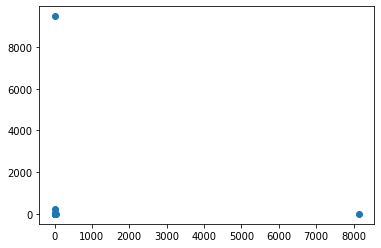

In [54]:
plt.scatter([1, 2, 3, 4, 5, 6, 7, 8, 15, 18, 34, 8142], [9469, 245, 52, 15, 9, 2, 3, 1, 1, 1, 1, 1])

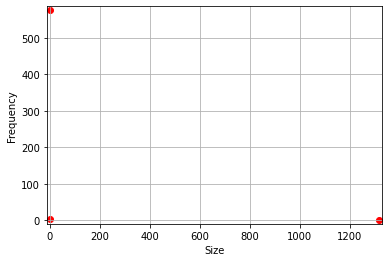

In [55]:
test = make_distribution_graph(analysis_dic[1][Properties.DIST_CC.value], '', True)

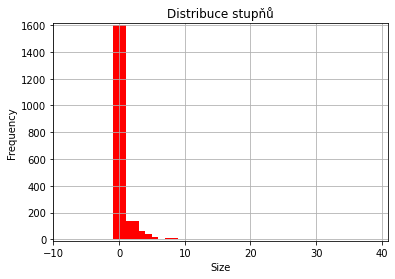

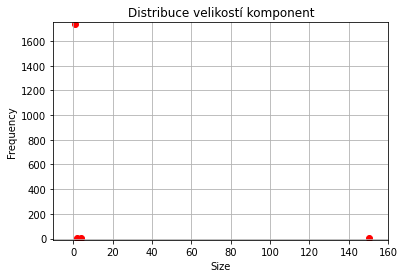

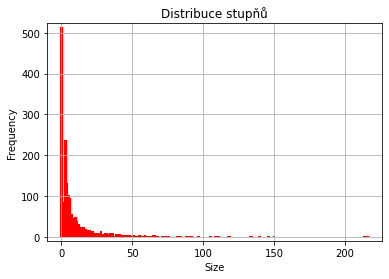

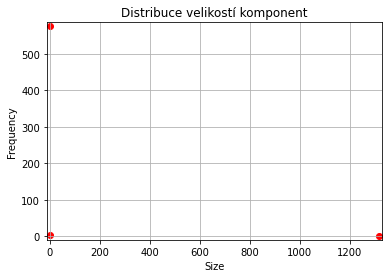

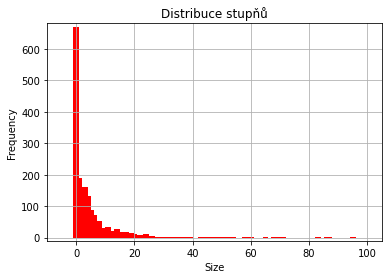

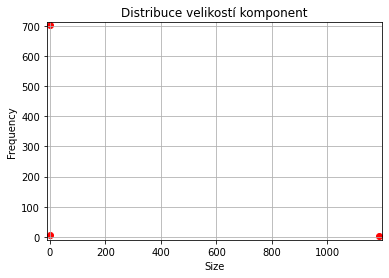

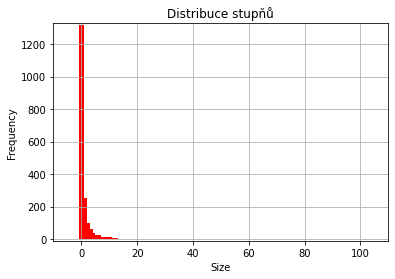

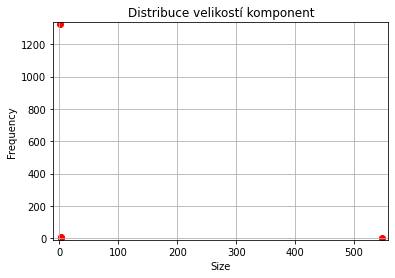

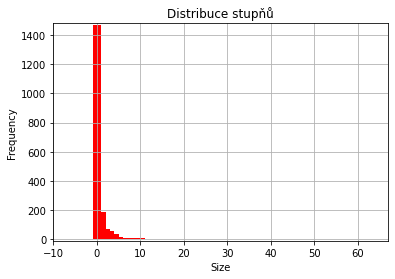

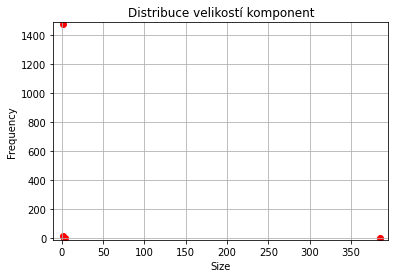

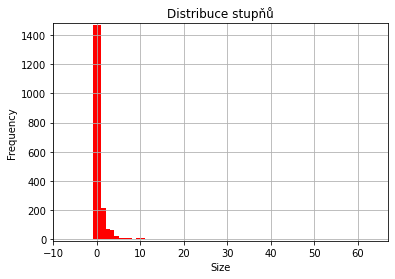

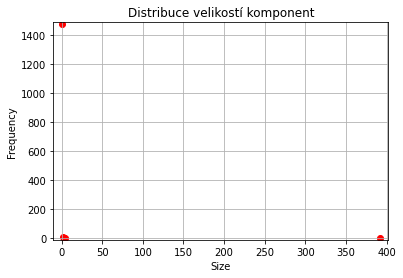

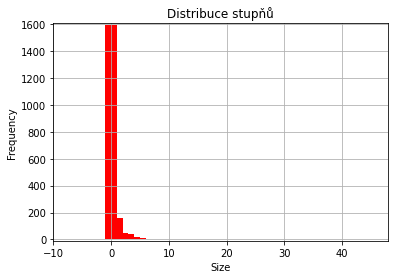

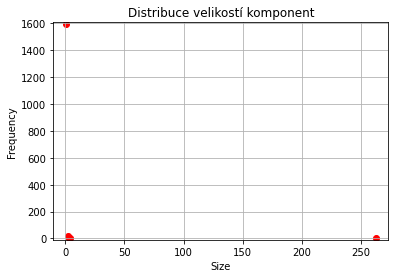

In [128]:
dfs = []
for k in analysis_dic.keys():
    df = create_analysis_df(analysis_dic[k], k)
    dist_degress = make_distribution_graph(analysis_dic[k][Properties.DIS_D.value], Properties.DIS_D.value)
    dist_cc = make_distribution_graph(analysis_dic[k][Properties.DIST_CC.value], Properties.DIST_CC.value, True)
    graphs = [(dist_degress, Properties.DIS_D.value), (dist_cc, Properties.DIST_CC.value)]
    save_graphs(graphs, k)
    dfs.append(df)
    
with pd.ExcelWriter(f'{PATH_TO_EXCELS}output.xlsx') as writer:  
    for i, df in enumerate(dfs):
        name = LAYER_LABELS[i]
        df.to_excel(writer, sheet_name=name)

In [57]:
PATH_TO_TOGETHER_GRAPHS = f'{PATH_TO_GRAPHS}\\together'

In [58]:
def get_cumulative(distribution_array):
    sizes, times = zip(*distribution_array.items())
    print(distribution_array)
    suma = np.sum(times)
    r_freq = [t/suma for t in times]
    sizes = list(sizes) + [sizes[-1] + 1]
    sizes = normalize(sizes)
    
    cum_freq = [0]
    for f_i, f_v in enumerate(r_freq[0:len(r_freq)]):
        cum_freq.append(cum_freq[f_i] + f_v)
        
    return sizes, cum_freq
    
    

In [59]:
#get_cumulative(analysis_dic[0][Properties.DIST_CC.value])

In [60]:
def make_cumulative_distribution(analysis, key, true_names=False, save=True):
    fig, ax = plt.subplots()
    graph_title = f'Kumulativni {str(key).lower()}'
    ax.set_title(graph_title)
    ax.set_ylabel('Relative frequency')
    ax.set_xlabel('Normalized size')
    
    for k in analysis:
        name = LAYER_LABELS[k] if true_names else f'{k}'
        current_analysis = analysis[k]
        distribution_values = current_analysis[key]
        result = get_cumulative(distribution_values)
        ax.plot(*result, label=name)
        
      
    ax.legend()
    if save:
        fig.savefig(f'{PATH_TO_TOGETHER_GRAPHS}\\cumulative_freq_{str(key).lower()}.jpg') 
        
    return fig, ax
    
    
    

{0: 1603, 2: 138, 3: 64, 4: 41, 5: 19, 6: 5, 7: 3, 8: 9, 9: 6, 10: 1, 12: 2, 15: 1, 16: 1, 17: 1, 22: 2, 24: 1, 31: 2}
{0: 513, 1: 62, 2: 84, 3: 237, 4: 132, 5: 103, 6: 94, 7: 56, 8: 46, 9: 44, 10: 48, 11: 38, 12: 31, 13: 24, 14: 22, 15: 23, 16: 23, 17: 20, 18: 17, 19: 16, 20: 16, 21: 11, 22: 14, 23: 9, 24: 9, 25: 9, 26: 10, 27: 8, 28: 15, 29: 7, 30: 3, 31: 8, 32: 10, 33: 3, 34: 6, 35: 8, 36: 9, 37: 1, 38: 2, 39: 6, 40: 7, 41: 6, 42: 5, 43: 2, 44: 4, 45: 5, 46: 3, 47: 3, 48: 3, 49: 2, 50: 1, 51: 3, 52: 2, 54: 2, 55: 4, 56: 1, 58: 2, 59: 4, 60: 2, 62: 2, 63: 1, 64: 1, 65: 3, 66: 3, 67: 2, 68: 1, 71: 1, 72: 1, 73: 1, 74: 1, 76: 1, 82: 1, 84: 1, 88: 2, 89: 1, 90: 1, 92: 2, 97: 1, 105: 1, 109: 2, 111: 1, 118: 1, 119: 1, 133: 1, 134: 2, 140: 1, 146: 1, 150: 1, 214: 1, 216: 1}
{0: 671, 1: 191, 2: 150, 3: 162, 4: 131, 5: 87, 6: 73, 7: 48, 8: 54, 9: 31, 10: 28, 11: 34, 12: 22, 13: 16, 14: 26, 15: 18, 16: 12, 17: 17, 18: 10, 19: 15, 20: 12, 21: 10, 22: 7, 23: 9, 24: 11, 25: 5, 26: 6, 27: 3, 28:

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Kumulativni distribuce stupňů'}, xlabel='Normalized size', ylabel='Relative frequency'>)

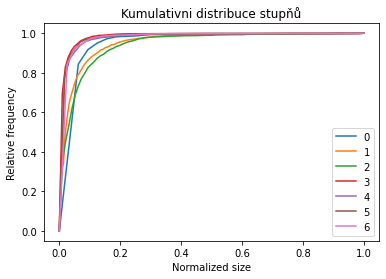

In [61]:
make_cumulative_distribution(analysis_dic, Properties.DIS_D.value)

{1: 1741, 2: 2, 4: 1, 150: 1}
{1: 576, 2: 2, 1319: 1}
{1: 702, 2: 5, 1187: 1}
{1: 1326, 2: 8, 3: 3, 548: 1}
{1: 1477, 2: 15, 3: 1, 4: 1, 385: 1}
{1: 1475, 2: 11, 3: 2, 4: 1, 392: 1}
{1: 1597, 2: 16, 3: 1, 4: 1, 263: 1}


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Kumulativni distribuce velikostí komponent'}, xlabel='Normalized size', ylabel='Relative frequency'>)

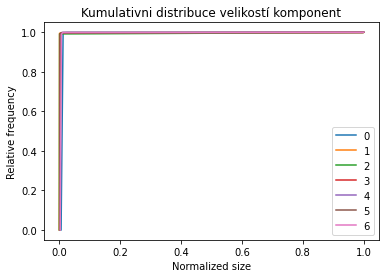

In [62]:
make_cumulative_distribution(analysis_dic, Properties.DIST_CC.value)

In [63]:
PATH_SAVE_MULTILAYER_PROPERTIES = f'outputs\\multilayer\\'

In [64]:
PATH_R_MULTINET_LIB_INPUT = f'outputs\\r\\'

In [65]:
NUMBER_OF_STEPS = 10 #random walk
NUMBER_OF_TIMES = 100 #random walk
MOVE_TO_LAYER = -99 #idk :D

In [66]:
class MultiLevelNet:
    def __init__(self, matrix, actors, layers, layers_name = None, calculate=False, lab=8):
        self.lab = lab
        size = int(len(matrix) / layers)
        self.number_of_layers = layers
        self.multi_net = self.create_matrix(matrix, layers)
        self.actors = actors
        self.aindex2actor = {i:actors[i] for i in range(len(actors))}
        self.layers_name = layers_name
        self.calculate = calculate

        if self.calculate:
            print('Running calculate section')
            self.df = self.calculate_res_dataframe()
            #self.layer_df = self.calculate_layer_properties()
            self.save_df(self.df, 'multilayer.csv')
            #self.save_df(self.layer_df, 'layer.csv')

    def calculate_layer_properties(self):
        d_result = {}
        for l in range(self.number_of_layers):
            print(f'For layer {l} - num_actors:{len(self.actors)}')
            l_n = self.layers_name[l]
            l_res = {}
            
            
            for i, a in enumerate(self.actors):
                if i % 100 == 0:
                    print(f'actor {i}')
                l_a_d = self.degree_centrality(i, [l])
                excl_neig = self.exclusive_neighborhood(i, [l])
                excl_rel = self.exclusive_relevance(i, [l])
                l_res[self.aindex2actor[i]] = {'Degree': round(l_a_d, 3), 'Exclu. Nei': round(excl_neig, 3), 'Exclu. Rele': round(excl_rel, 3)} 
        
            d_result[l_n] = l_res


        properties = ['Degree','Exclu. Nei','Exclu. Rele']
        header = pd.MultiIndex.from_product([self.layers_name,
                                            properties],
                                            names=['Layer name','Property'])


        columns=['Degree deviation', 'Degree', 'Neighbors', 'Connective redudancy']
        data = np.zeros((len(self.actors), 3 * self.number_of_layers), dtype='float32')

        for i, k_i in enumerate(d_result.keys()): #layers as key
            for j, prop in enumerate(properties):
                constructed_array = []
                for _, k_j in enumerate(d_result[k_i].keys()): #actors as key
                    value = d_result[k_i][k_j][prop]
                    constructed_array.append(value)
                position = i * len(properties) + j
                data[:, position] = constructed_array    
            
        df = pd.DataFrame(data, columns=header, index=self.actors)
        return df

    def exclusive_relevance(self, actor, L):
        nom = self.exclusive_neighborhood(actor, L)
        den = self.neighborhood_centrality(actor,self.generate_all())
        if den == 0:
            return 0
        return nom / den


    def calculate_res_dataframe(self):
        d_res = []
        d_c_res = []
        neighborhood_res = []
        redudancy_res = []

        for i, a in enumerate(self.actors):
            if i % 100 == 0:
                print(f'actor {i}')
            L = list(range(self.number_of_layers))
            d = self.degree_centrality(i, L)
            d_c = self.degree_deviation(i, L)
            neighborhood = self.neighborhood_centrality(i, L)
            redudancy = self.connective_redundancy(i, L)            



            d_res.append(d)
            d_c_res.append(round(d_c, 3))
            neighborhood_res.append(neighborhood)
            redudancy_res.append(round(redudancy, 3))


        columns=['Degree deviation', 'Degree', 'Neighbors', 'Connective redudancy']
        df = pd.DataFrame({columns[0]: d_c_res, columns[1]: d_res, columns[2]: neighborhood_res, columns[3]: redudancy_res},index=self.actors)
        return df

    def save_df(self, df, name):
        df.to_csv(f'{PATH_SAVE_MULTILAYER_PROPERTIES}{name}', sep=';')


    def create_matrix(self, matrix, layers):
        full_size = len(matrix)
        layer_size = int(full_size / layers)
        self.layer_size = layer_size 

        metricies = np.zeros((layer_size, layer_size, layers), dtype='uint8')    
        for i in range(layers):            
            f = layer_size*i
            t = layer_size*(i+1)
            layer_matrix = matrix[f:t]
            metricies[:, :, i] = layer_matrix

        if(not np.all(metricies[0, :, 0] == matrix[0, :])):
            raise Exception("Preprocessing was not correct")

        return metricies

    def degree_centrality(self, actor, L):
        sum_matrix = np.sum(self.multi_net[:, :, L], axis=-1)
        actor_vector = sum_matrix[actor, :]
        degree = int(np.sum(actor_vector))
        return degree

    def degree_deviation(self, actor, L):
        same = self.degree_centrality(actor, L) / len(L)
        s = 0
        for l in L:
            l_c = self.degree_centrality(actor, [l])
            # print(l_c)
            calc = pow(l_c - same, 2)
            s += calc
        res = s / len(L) 
        return math.sqrt(res)

    def generate_all(self):
        return list(range(self.number_of_layers))

    def neighbors(self, actor, L=None):
        L = L
        if L is None:
            L = self.generate_all()

        sum_matrix = np.sum(self.multi_net[:, :, L], axis=-1)
        actor_vector = sum_matrix[actor, :]
        neighbors = np.argwhere(actor_vector > 0)
        return neighbors.flatten()

    def neighborhood_centrality(self, actor, L):
        return len(self.neighbors(actor, L))

    def connective_redundancy(self, actor, L):
        nom = self.neighborhood_centrality(actor, L)
        den = self.degree_centrality(actor, L)
        x = 0
        if den != 0:
            x = nom / den  
        return 1 - x
        
    def exclusive_neighborhood(self, actor, L):
        xneighborhood = 0
        first = self.neighbors(actor, L)
        al = set(self.generate_all())
        i = set(L)
        res = al.difference(i)
        second = self.neighbors(actor, list(res))
        xneighborhood = set(first).difference(set(second))
        return len(list(xneighborhood))


    def flattening(self):
        flat_net = np.zeros((self.layer_size, self.layer_size), dtype='uint8')
        for x in range(self.layer_size):
            for y in range(self.layer_size):
                res = np.sum(self.multi_net[x, y, :])                
                flat_net[x, y] = 1 if res > 0 else 0
        print(pd.DataFrame(flat_net))


    def random_walk(self, v_start, l_start, all_layers, number_of_steps):
        history = [] #((v, l), (v, l)) ((from), (to))
        current_vertex = v_start #actor
        current_layer = l_start


     
        for step in range(number_of_steps):

            f = (current_vertex, current_layer)

            n = list(self.neighbors(current_vertex, [current_layer]))
            n.append(MOVE_TO_LAYER)
            choice = random.choice(n)

            if choice == MOVE_TO_LAYER:
                rem_layers = list(filter(lambda x: x != current_layer, all_layers))
                choice_layer = random.choice(rem_layers) 
                current_layer = choice_layer
                # print('move to another layer')
            else:
                current_vertex = choice
                # print('move to another vertex')
            # print(n)

            t = (current_vertex, current_layer)

            history.append((f, t))
        
        return history


    def resolve_ava_layers(self, actor_index):
        return self.generate_all()


    def occupation_centrality(self, walks, number_of_times = NUMBER_OF_TIMES):
        occupation_centrality_res = {actor_i: 0 for actor_i in walks.keys()}        
        for actor_i in walks.keys():
            init_actor_walks = walks[actor_i]
            for walk_history in init_actor_walks:
                start = walk_history[0][0][0]
                end = walk_history[-1][1][0]
                occupation_centrality_res[end] += 1


        calculated = {actor_i:(occupation_centrality_res[actor_i]/(number_of_times*len(list(walks.keys())))) for actor_i, times in occupation_centrality_res.items()}

        return occupation_centrality_res, calculated


    def make_random_walks(self, number_of_steps = NUMBER_OF_STEPS, number_of_times = NUMBER_OF_TIMES):
        actors = list(range(len(self.actors)))
        # actors = [0]
        # print(actors)
        walks = {}
        for actor_index in actors:
            walks[actor_index] = []
            layers_to_start = self.resolve_ava_layers(actor_index)
            for walk_index in range(number_of_times):
                start_layer = random.choice(layers_to_start)
                random_walk_history = self.random_walk(actor_index, start_layer, layers_to_start, number_of_steps)
                walks[actor_index].append(random_walk_history)

        return self.occupation_centrality(walks)


    def save_net_for_r(self):
        output = f"#VERSION\n3.0\n#TYPE\nmultiplex\n#EDGES"

        for n_l in range(self.number_of_layers):
            layer_name = self.layers_name[n_l]
            for a_y_i, y in enumerate(self.multi_net[:, :, n_l]):
                from_actor = self.aindex2actor[a_y_i]
                for a_x_i, x in enumerate(y):
                    if x == 1:
                        to_actor = self.aindex2actor[a_x_i]
                        output += f'\n{from_actor},{to_actor},{layer_name}'

        with open(f'{PATH_R_MULTINET_LIB_INPUT}multinet.mpx', 'w') as file:
            file.write(output)
        

In [67]:
matrix_all = None
i = 0
while i < (len(Gs)):
    print(i)
    if i == 0:
        # 0  1
        matrix_all = np.vstack((nx.to_numpy_matrix(Gs[i], dtype='uint8'), nx.to_numpy_matrix(Gs[i+1], dtype='uint8')))
        i += 1
    else:
         matrix_all = np.vstack((matrix_all, nx.to_numpy_matrix(Gs[i], dtype=int)))
        # x 2
    i += 1

0
2
3
4
5
6


In [68]:
LABELS = list(Gs[0].nodes()) #names of actors

In [ ]:
ml_net = MultiLevelNet(matrix_all, LABELS, NUMBER_OF_LAYERS, LAYER_LABELS, True)

Running calculate section
actor 0
actor 100
actor 200
actor 300
actor 400
actor 500
actor 600
actor 700
actor 800
actor 900


In [71]:
ml_net.save_net_for_r()

In [75]:
for i, g in enumerate(Gs):
    print(i, g)

0 
1 
2 


# Prediction links

In [69]:

IGNORE_ZERO = False
VERBOSE = True


STATIC_THRESHOLD = 0.2

In [70]:
class Performace:
    def __init__(self, title=""):
        pass
        self.sensitivity = 0
        self.specificity = 0
        self.precision = 0
        self.recall = 0
        self.fallout = 0
        self.accuracy = 0
        self.title = title
        self.time = 0
        self.threshold = 0


    def make_calculation(self, nom, den):
        if den == 0:
            return 0
        return nom/den

    def calc_sensitivity(self, true_pos, true_neg, false_pos, false_neg):
        nom = true_pos
        den = true_pos + false_neg
        self.sensitivity = self.make_calculation(nom, den)

    def calc_specificity(self, true_pos, true_neg, false_pos, false_neg):
        nom = true_neg
        den = false_pos + true_neg
        self.specificity = self.make_calculation(nom, den)
        
    def calc_precision(self, true_pos, true_neg, false_pos, false_neg):
        nom = true_pos
        den = true_pos + false_pos
        self.precision = self.make_calculation(nom, den)

    def calc_recall(self, true_pos, true_neg, false_pos, false_neg):
        nom = true_pos
        den = true_pos + false_neg
        self.recall = self.make_calculation(nom, den)

    def calc_fallout(self, true_pos, true_neg, false_pos, false_neg):
        nom = false_pos
        den = false_pos + true_neg
        self.fallout = self.make_calculation(nom, den)

    def calc_accuracy(self, true_pos, true_neg, false_pos, false_neg):
        nom = true_pos + true_neg
        p = true_pos + false_pos
        n = true_neg + false_neg
        den = p + n
        self.accuracy = self.make_calculation(nom, den)

    def calculate(self, tuple_confusion_matrix):
        self.calc_sensitivity(*tuple_confusion_matrix)
        self.calc_specificity(*tuple_confusion_matrix)
        self.calc_precision(*tuple_confusion_matrix)
        self.calc_recall(*tuple_confusion_matrix)
        self.calc_fallout(*tuple_confusion_matrix)
        self.calc_accuracy(*tuple_confusion_matrix)

    def get_dictionary(self):
        dic = {}
        dic['Sensitivity'] = self.sensitivity
        dic['Specificity'] = self.specificity
        dic['Precision'] = self.precision
        dic['Recall'] = self.recall
        dic['Fallout'] = self.fallout
        dic['Accuracy'] = self.accuracy
        dic['Time'] = self.time
        dic['Threshold'] = self.threshold
        return dic

    def __str__(self):
        res = f"{self.title.upper()}\n\n"
        res += f'\tSensitivity:{self.sensitivity}\n'
        res += f'\tSpecificity:{self.specificity}\n'
        res += f'\tPrecision:{self.precision}\n'
        res += f'\tRecall:{self.recall}\n'
        res += f'\tFallout:{self.fallout}\n'
        res += f'\tAccuracy:{self.accuracy}\n'
        return res

        




In [71]:
from enum import Enum
import numpy as np
import math


class PrediLink(Enum):
    AdamicAdar = "AdamicAdar"
    ResourceAllocationIndex = "ResourceAllocationIndex"
    CosineSimilarity = 'CosineSimilarity'
    SorensenIndex =  "SorensenIndex"
    CARBasedCommonNeighborIndex = 'CARBasedCommonNeighborIndex' 
    CommonNeighbors = 'CommonNeighbors'
    JaccardCoefficient = 'JaccardCoefficient'
    PreferentialAttachment = 'PreferentialAttachment'  



def create_matrix_deps_on_method(matrix, method):
    """Creates matrix according to predict link method
    """
    result_A = np.zeros(shape=matrix.shape, dtype="float32")
    for y in range(result_A.shape[0]):
        y_vertex = matrix[y, :]
        for x in range(y+1,result_A.shape[1]):
            if y == x:
                continue
            x_vertex = matrix[x, :]
            res = method(y_vertex, x_vertex, matrix)
            result_A[y, x] = res
    return result_A



def adamic_adar_matrix(matrix):
    return create_matrix_deps_on_method(matrix, adamic_adar_calc)

def resource_allocation_index_matrix(matrix):
    return create_matrix_deps_on_method(matrix, resource_allocation_index_calc)

def cosine_similarity_matrix(matrix):
    return create_matrix_deps_on_method(matrix, cosine_similarity_calc)

def sorensen_index_matrix(matrix):
    return create_matrix_deps_on_method(matrix, sorensen_index_calc)

def car_based_common_neighbor_index_matrix(matrix):
    return create_matrix_deps_on_method(matrix, car_based_common_neighbor_index_calc)


def common_neighbors_matrix(matrix):
    return create_matrix_deps_on_method(matrix, cn_calc)

def preferential_attachment_matrix(matrix):
    return create_matrix_deps_on_method(matrix, prefa_calc)

def jaccard_matrix(matrix):
    return create_matrix_deps_on_method(matrix, jaccard_calc)


def adamic_adar_calc(y, x, matrix):
    """Suma through 1/log(z) intersect of neighbors(set(z)) x, y.
    """
    edges_y = np.where(y > 0)
    edges_x = np.where(x > 0)
    set_y = set(np.array(edges_y).flatten()) 
    set_x = set(np.array(edges_x).flatten())
    intersect = set_y.intersection(set_x)
    suma = 0
    for e_z in intersect:
        vertex_z = matrix[e_z, :]
        k_z = len(np.where(np.array(vertex_z) > 0))
        suma += 1 / (math.log(k_z))
    return suma

def resource_allocation_index_calc(y, x, matrix):
    """It highly penalizes higer degree nodes.
    """
    edges_y = np.where(y > 0)
    edges_x = np.where(x > 0)
    set_y = set(np.array(edges_y).flatten()) 
    set_x = set(np.array(edges_x).flatten())
    intersect = set_y.intersection(set_x)
    suma = 0
    for e_z in intersect:
        vertex_z = matrix[e_z, :]
        k_z = len(np.where(np.array(vertex_z) > 0))
        suma += 1 / k_z
    return suma


def cosine_similarity_calc(y, x, matrix):
    edges_y = np.where(y > 0)
    edges_x = np.where(x > 0)
    set_y = set(np.array(edges_y).flatten()) 
    set_x = set(np.array(edges_x).flatten())
    intersect = set_y.intersection(set_x)
    nom = len(intersect)
    k_x = len(edges_x)
    k_y = len(edges_y)
    den = math.sqrt(k_x*k_y)
    if den == 0:
        return 0
    else:
        return nom / den

def sorensen_index_calc(y, x, matrix):
    edges_y = np.where(y > 0)
    edges_x = np.where(x > 0)
    set_y = set(np.array(edges_y).flatten()) 
    set_x = set(np.array(edges_x).flatten())
    intersect = set_y.intersection(set_x)
    nom = len(intersect)
    k_x = len(edges_x)
    k_y = len(edges_y)  
    nom = 2 * nom
    den = k_x + k_y

    if den == 0:
        return 0
    else:
        return nom / den 

def car_based_common_neighbor_index_calc(y, x, matrix):
    CN_part = cn_calc(y, x)

    edges_y = np.where(y > 0)
    edges_x = np.where(x > 0)
    set_y = set(np.array(edges_y).flatten()) 
    set_x = set(np.array(edges_x).flatten())
    intersect = set_y.intersection(set_x)   
    suma = 0
    for z in intersect:
        vertex_z = matrix[z, :]
        n_z = np.where(np.array(vertex_z) > 0)
        set_n_z = set(n_z)
        y_z = set_n_z.intersection(intersect)
        suma += len(y_z) / 2
    return CN_part * suma



def cn_calc(y, x, matrix):
    edges_y = np.where(y > 0)
    edges_x = np.where(x > 0)
    set_y = set(np.array(edges_y).flatten()) 
    set_x = set(np.array(edges_x).flatten())
    intersect = set_y.intersection(set_x)
    same = len(intersect)
    return same

def prefa_calc(y, x, matrix):
    k_y_w = np.argwhere(y > 0).flatten()
    k_x_w = np.argwhere(x > 0).flatten()
    k_y = len(k_y_w)
    k_x = len(k_x_w)
    return k_y * k_x

def jaccard_calc(y, x, matrix):
    edges_y = np.where(y > 0)
    edges_x = np.where(x > 0)
    set_y = set(np.array(edges_y).flatten()) 
    set_x = set(np.array(edges_x).flatten()) 
    intersect = set_y.intersection(set_x)
    unioned = set_y.union(set_x)
    nom = len(intersect)
    den = len(unioned)
    if den == 0:
        return 0
    return nom/den

def apply_threshold(matrix, threshold):
    thresholded_matrix = np.copy(matrix)
    res = np.where(thresholded_matrix > threshold, 1, 0)
    return res

def create_confusion_tuple(matrix, m_matrix, predicted_matrix, t):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for y in range(matrix.shape[0]):
        for x in range(y+1, matrix.shape[1]):
            available_value = matrix[y, x]
            predicted_value = m_matrix[y, x]

            if IGNORE_ZERO and predicted_matrix is not None and predicted_matrix[y, x] == 0:
                continue

            if available_value == True and predicted_value == True:
                true_positive += 1

            if available_value == False and predicted_value == False:
                true_negative += 1

            if available_value == False and predicted_value == True:
                false_positive += 1

            if available_value == True and predicted_value == False:
                false_negative += 1

    res = (true_positive, true_negative, false_positive, false_negative)

    if VERBOSE:
        print(f'{t}\n\n\n\tTrue positive {true_positive}\n\tTrue negative {true_negative}\n\tFalse positive {false_positive}\n\tFalse negative {false_negative}\n')
    return res



    
#TODO: make all methods
prediction_link_dictionary = {
    PrediLink.AdamicAdar: adamic_adar_matrix, #TODO
    PrediLink.ResourceAllocationIndex: resource_allocation_index_matrix,
    PrediLink.CosineSimilarity: cosine_similarity_matrix,
    PrediLink.SorensenIndex: sorensen_index_matrix,
    PrediLink.CARBasedCommonNeighborIndex: car_based_common_neighbor_index_matrix,
    PrediLink.CommonNeighbors: common_neighbors_matrix,
    PrediLink.JaccardCoefficient: jaccard_matrix,
    PrediLink.PreferentialAttachment: preferential_attachment_matrix,
}

In [87]:
import pandas as pd
import networkx as nx
import time

class Controller:
    def __init__(self):
        pass
    
    def set_adj_A(self, g):
        self.adj_A = nx.to_numpy_matrix(g, dtype='uint8')

        
    def run_prediction(self, index, threshold=STATIC_THRESHOLD):
        print('Start prediction')
        predictions = {}
        methods = list(prediction_link_dictionary.values())
        methods_name = list(prediction_link_dictionary.keys())

        method_name = methods_name[index].value
        selected_method = methods[index]

        prediction_results = self.make_calculation(self.adj_A, selected_method, threshold, method_name)
        prediction_results[1].threshold = threshold

        predictions[method_name] = prediction_results
        print('End prediction')
        return predictions



    def make_calculation(self, matrix, method, threshold=STATIC_THRESHOLD, method_type=""):
        start = time.time()
        matrix_method = method(matrix)
        matrix_method_thresholded = apply_threshold(matrix_method, threshold)
        title = f"{method_type}"
        calculated_tuple = create_confusion_tuple(matrix, matrix_method_thresholded, matrix_method, title)
        perf = Performace(title)
        perf.calculate(calculated_tuple)
        end = time.time()
        perf.time = end - start
        return calculated_tuple, perf

    def make_step_analysis(self, f, to, step, method_index):
        print('Starting step analysis')
        predictions = {}

        methods = list(prediction_link_dictionary.values())
        methods_name = list(prediction_link_dictionary.keys())

        method_name = methods_name[method_index].value
        selected_method = methods[method_index]

        
        matrix = self.adj_A
        matrix_method = selected_method(matrix)
        print('Matrix calculated')
        
        
        i = f
        while i < to:
            print(f'Threshold {i}')
            thresh = i
            matrix_method_thresholded = apply_threshold(matrix_method, thresh)
            title = f"{method_name}"
            calculated_tuple = create_confusion_tuple(matrix, matrix_method_thresholded, matrix_method, title)
            perf = Performace(title)
            perf.calculate(calculated_tuple)
            prediction_results = (calculated_tuple, perf)
            prediction_results[1].threshold = i
            predictions[i] = prediction_results
            i+=step
            
        return predictions



In [80]:
met = list(prediction_link_dictionary.keys())
print(met)
for i in range(len(met)):
    print(f'Index={i} method={met[i]}')

[<PrediLink.AdamicAdar: 'AdamicAdar'>, <PrediLink.ResourceAllocationIndex: 'ResourceAllocationIndex'>, <PrediLink.CosineSimilarity: 'CosineSimilarity'>, <PrediLink.SorensenIndex: 'SorensenIndex'>, <PrediLink.CARBasedCommonNeighborIndex: 'CARBasedCommonNeighborIndex'>, <PrediLink.CommonNeighbors: 'CommonNeighbors'>, <PrediLink.JaccardCoefficient: 'JaccardCoefficient'>, <PrediLink.PreferentialAttachment: 'PreferentialAttachment'>]
Index=0 method=PrediLink.AdamicAdar
Index=1 method=PrediLink.ResourceAllocationIndex
Index=2 method=PrediLink.CosineSimilarity
Index=3 method=PrediLink.SorensenIndex
Index=4 method=PrediLink.CARBasedCommonNeighborIndex
Index=5 method=PrediLink.CommonNeighbors
Index=6 method=PrediLink.JaccardCoefficient
Index=7 method=PrediLink.PreferentialAttachment


In [88]:
c = Controller()
c.set_adj_A(Gs[0])

In [119]:
METHOD_INDEX = 2
THRESHOLD = 5

METHOD_NAME = met[METHOD_INDEX].value

In [120]:
METHOD_NAME

'CosineSimilarity'

In [121]:
#pred = c.run_prediction(METHOD_INDEX, THRESHOLD)

In [122]:
THRESHOLD_FROM = 1
THRESHOLD_TO = 10
THRESHOLD_STEP = 0.5

In [123]:
pred = c.make_step_analysis(THRESHOLD_FROM, THRESHOLD_TO, THRESHOLD_STEP, METHOD_INDEX) #graphs

Starting step analysis
Matrix calculated
Threshold 1
CosineSimilarity


	True positive 258
	True negative 1801655
	False positive 234
	False negative 4

Threshold 1.5
CosineSimilarity


	True positive 37
	True negative 1801827
	False positive 62
	False negative 225

Threshold 2.0
CosineSimilarity


	True positive 9
	True negative 1801873
	False positive 16
	False negative 253

Threshold 2.5
CosineSimilarity


	True positive 5
	True negative 1801881
	False positive 8
	False negative 257

Threshold 3.0


KeyboardInterrupt: 

In [104]:
def create_prediction_df(prediction, columns=['TODO']):
    dic = {}
    confusion_labels = ['TRUE POSITIVE', 'TRUE NEGATIVE', 'FALSE POSITIVE', 'FALSE NEGATIVE']
    confusion_tuple, performance = prediction

    for label_index, label in enumerate(confusion_labels):
        value = confusion_tuple[label_index]
        dic[label] = value

    for k, v in performance.get_dictionary().items():
        dic[k] = v

    df = pd.DataFrame.from_dict(dic, orient='index', columns=columns)

    return df

In [111]:
def save_prediction(predictions, path):
    predictions_keys = list(predictions.keys())
    dfs = []

    for k in predictions_keys:
        prediction = predictions[k]
        dfs.append(create_prediction_df(prediction, [k]))

    with pd.ExcelWriter(path) as writer:
        #props_df = graph_analysis.get_df()
        #props_df.to_excel(writer, sheet_name='GraphProperties')
        for index, df in enumerate(dfs):
            sheet_name = predictions_keys[index]
            df.to_excel(writer, sheet_name=f'{sheet_name}')
            writer.save()

In [112]:
PATH_TO_SAVE_PREDICTIONS = f'outputs\\predictions\\'

In [113]:
directory = f'{PATH_TO_SAVE_PREDICTIONS}{METHOD_NAME}'
path = f'{directory}/{METHOD_NAME}.xlsx'
if not os.path.exists(directory):
    os.makedirs(directory)
save_prediction(pred, path)


# Graphs


saving graph Sensitivity
saving graph Specificity
saving graph Precision
saving graph Recall
saving graph Fallout
saving graph Accuracy
saving graph Time
saving graph Threshold


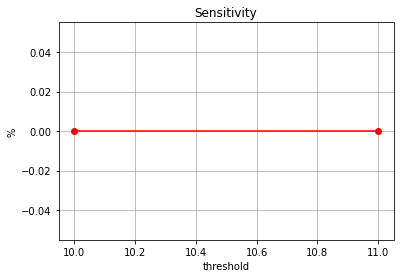

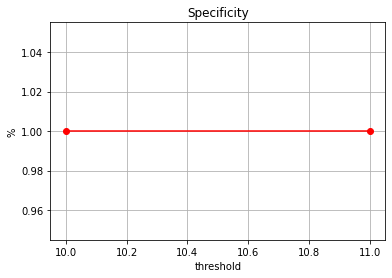

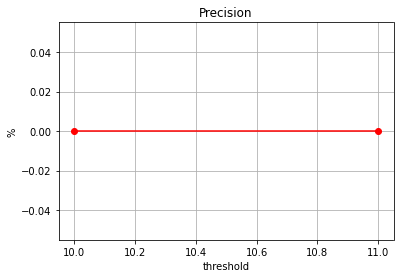

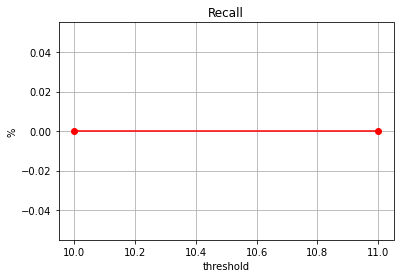

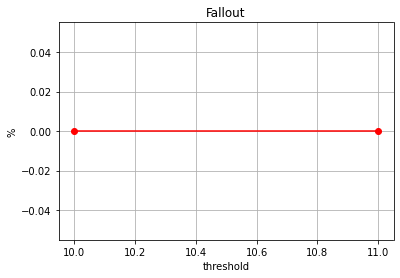

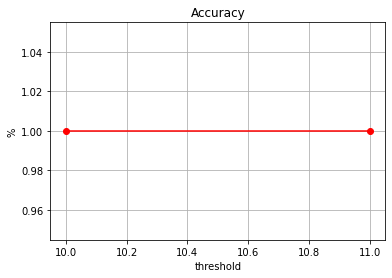

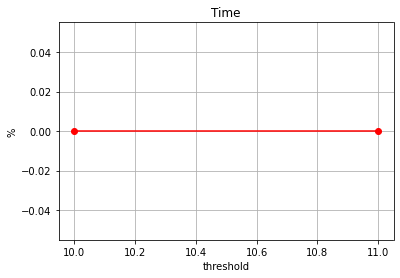

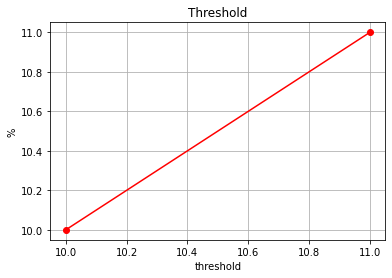

In [114]:
ys = {}

x = pred.keys() #thresholds
performances = pred.values()
titles = None

for performance in performances:
    for k,v in performance[1].get_dictionary().items():
        if k in ys:
            ys[k].append(v)
        else:
            ys[k] = [v]


#save graphs
for k, v in ys.items():
    print('saving graph', k)
    fig, ax = plt.subplots()
    ax.set_title(k)
    ax.set_xlabel('threshold')
    ax.set_ylabel('%')
    ax.grid()
    ax.plot(x, v, color='red', marker='o')
    fig.savefig(f'{directory}/{k}.jpg')
